In [2]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel


#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)
    
def Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fftshift(fft(ifftshift(Mplusband)))
    Fourier_minous=fftshift(fft(ifftshift(Mminousband)))
    return Fourier_plus,Fourier_minous

def Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size,Ground=False):
    if Ground:
        F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground=Ground)
    else:
        F_plus, F_minous = Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size)
    return F_plus[(N_size-1)//2-L+1:(N_size-1)//2+L], F_minous[(N_size-1)//2-L+1:(N_size-1)//2+L]

def Toeplitz_matrix(array,L):
    Toeplitz=np.zeros((L,L),dtype=np.complex)
    aux=0
    for i in range(L):
        #print(array[aux:aux+L][::-1].shape)
        Toeplitz[:,i]=array[aux:aux+L][::-1]
        aux+=1
    return Toeplitz
def Covariance_matrix(L,beta,mu,Gamma,Lambda,N_size,Ground=False):
    if Ground:
        circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size,Ground=Ground)
    else:
        circulant, anticirculant = Sample_subsystem(L,beta,mu,Gamma,Lambda,N_size)
    return (Toeplitz_matrix(circulant,L)+Toeplitz_matrix(anticirculant,L))/N_size



def Sample_from_chain(L,N_size,array_1,array_2):
    #Array_1 and Array_2 are 2 arrays with the circulant and the anticirculant part
    return array_1[(N_size-1)//2-L+1:(N_size-1)//2+L], array_2[(N_size-1)//2-L+1:(N_size-1)//2+L]
def Covariance_matrix_from_sample(L,N_size,array_1,array_2):
    Band_L_plus, Band_L_minous = Sample_from_chain(L,N_size,array_1,array_2)
    return (Toeplitz_matrix(Band_L_plus,L)+Toeplitz_matrix(Band_L_minous,L))/N_size

In [87]:
N_size=2*int(10**1)+1
L=31
mu=0
n=np.arange(-(N_size-1)/2,(N_size-1)/2 +1)
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=gap_temp
F_plus,F_minous=Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground=True)

In [20]:
from IPython.display import clear_output
for L in range(3,101,2):
    clear_output(wait=True)
    New_cov_matrix=Covariance_matrix_from_sample(L,N_size,F_plus,F_minous)
    A,S,B=np.linalg.svd(New_cov_matrix)
    n=np.arange(-(L-1)/2,(L-1)/2 +1)
    array_to_plot=sorted(-S+0.5,reverse=True)
    plt.plot(array_to_plot,label="Singular values")
    plt.plot(np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True)),label="Fermi distribution")
    plt.legend()
    plt.title("lenght of {}".format(L))
    plt.show()
    print(np.sqrt(np.sum(np.square(array_to_plot-np.array(sorted(Fermi_dirac(beta,mu,n,N=L),reverse=True))))))

ValueError: could not broadcast input array from shape (2) into shape (13)

In [35]:
F_max,F_min=Sample_from_chain(5,N_size,F_plus,F_minous)

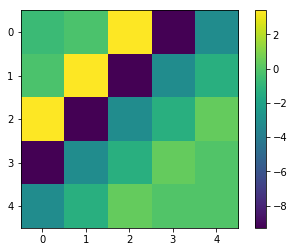

In [55]:

plt.imshow(Toeplitz_matrix(F_max[::-1],5)[::-1].real)
plt.colorbar()

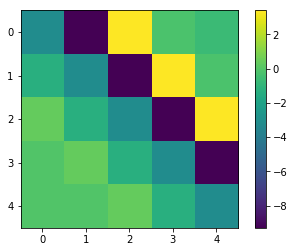

In [29]:
plt.imshow(Create_circulant(F_plus).real[:5,:5])
plt.colorbar()

In [32]:
Toeplitz_matrix(np.arange(-5,6),5)

array([[-1.+0.j,  0.+0.j,  1.+0.j,  2.+0.j,  3.+0.j],
       [-2.+0.j, -1.+0.j,  0.+0.j,  1.+0.j,  2.+0.j],
       [-3.+0.j, -2.+0.j, -1.+0.j,  0.+0.j,  1.+0.j],
       [-4.+0.j, -3.+0.j, -2.+0.j, -1.+0.j,  0.+0.j],
       [-5.+0.j, -4.+0.j, -3.+0.j, -2.+0.j, -1.+0.j]])

In [56]:
def Hankel_matrix(array,L):
    Hankel=np.zeros((L,L),dtype=np.complex)
    aux=0
    for i in range(L-1,-1,-1):
        #print(array[aux:aux+L][::-1].shape)
        Hankel[:,i]=array[aux:aux+L][::-1]
        aux+=1
    return Hankel

def Hankel_matrix_2(array,L):
    Hankel=Toeplitz_matrix(array[::-1],L)[::-1]
    return Hankel

In [58]:
np.arange(-5,6)

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5])

In [67]:
ifftshift(np.arange(-5,6))[::-1]

array([-1, -2, -3, -4, -5,  5,  4,  3,  2,  1,  0])

In [71]:
hankel(ifftshift(np.arange(-5,6))[::-1],np.roll(ifftshift(np.arange(-5,6))[::-1],1))

array([[-1, -2, -3, -4, -5,  5,  4,  3,  2,  1,  0],
       [-2, -3, -4, -5,  5,  4,  3,  2,  1,  0, -1],
       [-3, -4, -5,  5,  4,  3,  2,  1,  0, -1, -2],
       [-4, -5,  5,  4,  3,  2,  1,  0, -1, -2, -3],
       [-5,  5,  4,  3,  2,  1,  0, -1, -2, -3, -4],
       [ 5,  4,  3,  2,  1,  0, -1, -2, -3, -4, -5],
       [ 4,  3,  2,  1,  0, -1, -2, -3, -4, -5,  5],
       [ 3,  2,  1,  0, -1, -2, -3, -4, -5,  5,  4],
       [ 2,  1,  0, -1, -2, -3, -4, -5,  5,  4,  3],
       [ 1,  0, -1, -2, -3, -4, -5,  5,  4,  3,  2],
       [ 0, -1, -2, -3, -4, -5,  5,  4,  3,  2,  1]])

In [155]:
hankel(ifftshift(np.arange(-5,6))[::-1],np.roll(ifftshift(np.arange(-5,6))[::-1],1))[:3,:3]

array([[-1, -2, -3],
       [-2, -3, -4],
       [-3, -4, -5]])

F_plus,F_minous have to be taken differently

In [149]:
N_size=2*int(10**1)+1
L=5
mu=0
gap_temp=np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n))
beta=0.48
F_plus,F_minous=Get_Bands_Matrix(beta,mu,Gamma,Lambda,N_size,Ground=True)

In [150]:
A=np.arange(-5,6)
A[(len(A)-1)//2:]

array([0, 1, 2, 3, 4, 5])

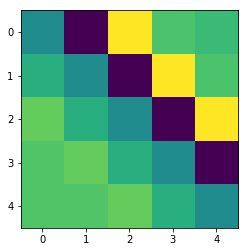

In [151]:
plt.imshow(Toeplitz_matrix(F_plus[(N_size-1)//2-L+1:(N_size-1)//2+L],L).real)

In [161]:
np.roll(fftshift(np.arange(-5,6)),1)[::-1]

array([-1, -2, -3, -4, -5,  5,  4,  3,  2,  1,  0])

In [ ]:
def Hankel_matrix(array,L):
    Hankel=np.zeros((L,L),dtype=np.complex)
    aux=0
    for i in range(L-1,-1,-1):
        #print(array[aux:aux+L][::-1].shape)
        Hankel[:,i]=array[aux:aux+L][::-1]
        aux+=1
    return Hankel

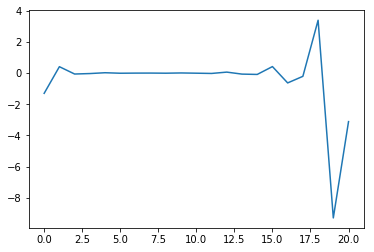

In [185]:
L=21
plt.plot(np.roll(fftshift(F_plus),1)[::-1][:2*L-1])
Hankel=np.zeros((L,L),dtype=np.complex)
new_array=np.roll(fftshift(F_plus),1)[::-1][:2*L-1]
aux=0
aux_array=new_array.copy()
for i in range(L):
    Hankel[:,i]=aux_array[:L]
    aux_array=np.roll(aux_array,-1)

In [186]:
np.roll(np.arange(-3,4),-1)

array([-2, -1,  0,  1,  2,  3, -3])

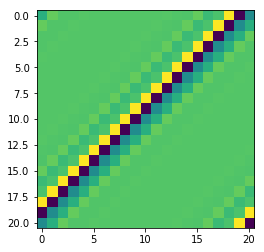

In [187]:
plt.imshow(Hankel.real)

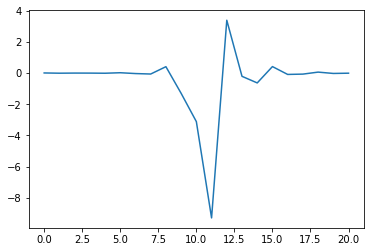

In [164]:
plt.plot(F_plus)

In [ ]:
Create_Toeplitz_Matrix(Array,)

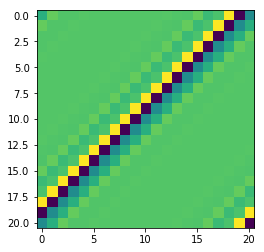

In [99]:
plt.imshow(hankel(ifftshift(F_plus)[::-1],np.roll(ifftshift(F_plus)[::-1],1)).real)

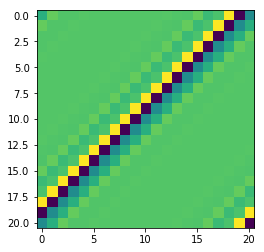

In [136]:
plt.imshow(Create_circulant(F_plus[::-1])[::-1].real)

# corrections to Teoplitz matrix

In [249]:
#sample the array of th plus band as follows

def Toeplitz_matrix(array):
    Toeplitz=np.zeros(((len(array)+1)//2,(len(array)+1)//2),dtype=np.complex)
    aux=array.copy()
    for i in range((len(array)+1)//2):
        Toeplitz[:,i]=aux[:(len(array)+1)//2][::-1]
        aux=np.roll(aux,-1)
    return Toeplitz

In [251]:
Toeplitz_matrix(np.arange(-5,6))

array([[ 0.+0.j,  1.+0.j,  2.+0.j,  3.+0.j,  4.+0.j,  5.+0.j],
       [-1.+0.j,  0.+0.j,  1.+0.j,  2.+0.j,  3.+0.j,  4.+0.j],
       [-2.+0.j, -1.+0.j,  0.+0.j,  1.+0.j,  2.+0.j,  3.+0.j],
       [-3.+0.j, -2.+0.j, -1.+0.j,  0.+0.j,  1.+0.j,  2.+0.j],
       [-4.+0.j, -3.+0.j, -2.+0.j, -1.+0.j,  0.+0.j,  1.+0.j],
       [-5.+0.j, -4.+0.j, -3.+0.j, -2.+0.j, -1.+0.j,  0.+0.j]])

In [211]:
A=np.arange(-(N_size-1)//2,(N_size-1)//2 +1)

In [226]:
L=5
A[(N_size-1)//2-L+1:(N_size-1)//2+L]

array([-4, -3, -2, -1,  0,  1,  2,  3,  4])

In [225]:
L=5
A[(N_size-L)//2:(N_size+L+1)//2]

array([-2, -1,  0,  1,  2])

In [203]:
len(F_plus[(N_size-1)//2-L+1:(N_size-1)//2+L])

8

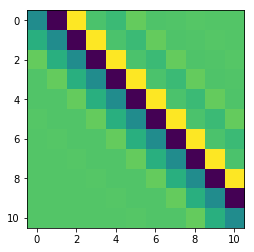

In [254]:
L=21
plt.imshow(Toeplitz_matrix(F_plus[(N_size-L)//2:(N_size+L+1)//2]).real)

In [70]:
np.roll(ifftshift(np.arange(-5,6))[::-1],1)

array([ 0, -1, -2, -3, -4, -5,  5,  4,  3,  2,  1])

9

In [82]:
for N_size in np.logspace(1,10,base=10):
    N_size=int(N_size)
    if N_size%2==0:
        N_size+=1
    print("N={}, {}".format(N_size,np.log(N_size)))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2 +1)
    print(np.min(Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n)))

N=11, 2.3978952727983707
0.4083762991436121
N=15, 2.70805020110221
0.42645559970020075
N=23, 3.1354942159291497
0.41561980621839123
N=35, 3.5553480614894135
0.4087946179093998
N=55, 4.007333185232471
0.4083762991436121
N=83, 4.418840607796598
0.4087035835285601
N=127, 4.844187086458591
0.40855381206822355
N=193, 5.262690188904886
0.4083083994271222
N=295, 5.68697535633982
0.408248319666545
N=449, 6.1070228877422545
0.40826409875365094
N=687, 6.532334292222349
0.40825736618820896
N=1049, 6.955592608396297
0.4082484094866595
N=1599, 7.377133712833954
0.40824994220456967
N=2443, 7.8009820712577405
0.4082490672445529
N=3727, 8.223358899479258
0.4082485190327803
N=5689, 8.646289764750648
0.40824829105760935
N=8685, 9.069352678675205
0.4082482920127107
N=13257, 9.49228099379885
0.40824829129504797
N=20235, 9.915169057309965
0.4082482917532216
N=30889, 10.338155412452387
0.4082482924777507
N=47149, 10.76106807892895
0.40824829060256823
N=71969, 11.18399074972698
0.4082482907850267
N=109855, 1

KeyboardInterrupt: 

# here we can set $\beta=0.48$ 

In [83]:
np.log(np.logspace(1,10,base=10))

array([ 2.30258509,  2.72550889,  3.14843268,  3.57135647,  3.99428026,
        4.41720406,  4.84012785,  5.26305164,  5.68597543,  6.10889923,
        6.53182302,  6.95474681,  7.3776706 ,  7.8005944 ,  8.22351819,
        8.64644198,  9.06936577,  9.49228957,  9.91521336, 10.33813715,
       10.76106094, 11.18398474, 11.60690853, 12.02983232, 12.45275612,
       12.87567991, 13.2986037 , 13.72152749, 14.14445129, 14.56737508,
       14.99029887, 15.41322266, 15.83614646, 16.25907025, 16.68199404,
       17.10491783, 17.52784163, 17.95076542, 18.37368921, 18.796613  ,
       19.2195368 , 19.64246059, 20.06538438, 20.48830817, 20.91123197,
       21.33415576, 21.75707955, 22.18000334, 22.60292714, 23.02585093])

# Test to fix the toeplitz matrix since it is not working for the general case

In [255]:
A=np.arange(-(N_size-1)//2,(N_size-1)//2+1)

In [256]:
fftshift(fft(ifftshift(Mplusband)))

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10])

In [265]:
ifftshift(A) # this is the result of fourier transform

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10, -10,  -9,
        -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1])

In [261]:
np.roll(ifftshift(A),-1)[::-1] # this is what we need for the circulant

array([  0,  -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10,  10,   9,
         8,   7,   6,   5,   4,   3,   2,   1])

In [266]:
np.roll(ifftshift(A),-1)[::-1][:4] # First column

array([ 0, -1, -2, -3])

In [268]:
ifftshift(A)[:5] # fisrt row

array([0, 1, 2, 3, 4])

In [275]:
N_size=5
A=np.arange(-(N_size-1)//2,(N_size-1)//2+1)
toeplitz(np.roll(ifftshift(A),-1)[::-1],ifftshift(A))

array([[ 0,  1,  2, -2, -1],
       [-1,  0,  1,  2, -2],
       [-2, -1,  0,  1,  2],
       [ 2, -2, -1,  0,  1],
       [ 1,  2, -2, -1,  0]])

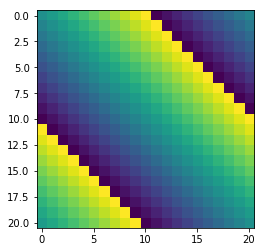

In [274]:
plt.imshow(toeplitz(np.roll(ifftshift(A),-1)[::-1],ifftshift(A)))

In [264]:
ifftshift(A)[::-1] # this for the anticirculant

array([ -1,  -2,  -3,  -4,  -5,  -6,  -7,  -8,  -9, -10,  10,   9,   8,
         7,   6,   5,   4,   3,   2,   1,   0])

# Now fourier returns the fourier modes from 0 to N

In [280]:
def Get_Bands_Matrix(Gamma,Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous
def Toeplitz_matrix(Fourier_plus,L):
    return toeplitz(np.roll(Fourier_plus,-1)[::-1][:L],Fourier_plus[:L])

In [290]:
N_size=21
B_plus,B_minous=Get_Bands_Matrix(Gamma,Lambda,N_size=N_size,Ground=True)

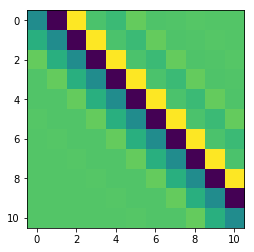

In [295]:
L=11
plt.imshow(Toeplitz_matrix(B_plus,L).real)

# Teoplitz matrix problem solved!!

In [296]:
ifftshift(A)[::-1] # this for the anticirculant

array([-1, -2,  2,  1,  0])

In [299]:
A
hankel(ifftshift(A)[::-1],np.roll(ifftshift(A)[::-1],1))

array([[-1, -2,  2,  1,  0],
       [-2,  2,  1,  0, -1],
       [ 2,  1,  0, -1, -2],
       [ 1,  0, -1, -2,  2],
       [ 0, -1, -2,  2,  1]])

In [322]:
N_size=11
A=np.arange(-(N_size-1)//2,(N_size-1)//2+1)

In [323]:
ifftshift(A)[::-1][:3] # First row and column

array([-1, -2, -3])

In [324]:
np.roll(ifftshift(A),2)[::-1][:3] # last row

array([-3, -4, -5])

In [325]:
hankel(ifftshift(A)[::-1][:3],np.roll(ifftshift(A),2)[::-1][:3])

array([[-1, -2, -3],
       [-2, -3, -4],
       [-3, -4, -5]])

In [339]:
def Hankel_matrix(Fourier_minous,L):
    return hankel(Fourier_minous[::-1][:L],np.roll(Fourier_minous,L-1)[::-1][:L])

In [336]:
N_size

11

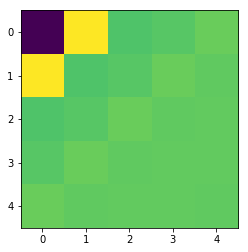

In [342]:
L=21
plt.imshow(Hankel_matrix(B_plus,5).real)

In [330]:
B_plus

array([-3.11492803e+00-2.77555756e-17j, -9.30161814e+00+1.94289029e-16j,
        3.39603635e+00+3.33066907e-16j, -2.06804271e-01+2.50069095e-17j,
       -6.30109278e-01-7.72189237e-18j,  4.19667334e-01+1.25348411e-16j,
       -8.49295202e-02-1.73053183e-17j, -6.41972220e-02-5.08254177e-17j,
        6.39909090e-02+1.08011987e-16j, -2.14466303e-02+6.17619661e-18j,
       -5.26690211e-03-2.31280291e-16j,  9.88742625e-03-1.83416369e-16j,
       -5.60870207e-03+6.17619661e-18j,  2.20897328e-03+5.48877600e-16j,
        2.11820136e-04-1.06156449e-16j, -7.99461695e-03-1.73053183e-17j,
        2.43313472e-02-2.05345256e-16j, -2.87437493e-02-1.21239524e-17j,
       -5.82882247e-02+2.50069095e-17j,  4.12473392e-01-2.47993772e-16j,
       -1.29887227e+00-2.64730535e-16j])

# updating the general Code

In [354]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
from ipywidgets import interactive
from scipy.fftpack import fft, ifft,ifftshift,fftshift
from IPython.display import display, HTML
from scipy.linalg import circulant
from scipy.linalg import toeplitz, hankel


#### --------- Definition of variables ------------------------

N_size=50001 #
Gamma=0.5
Lambda=0.5

#### ------------------------------------------------------------


def Create_circulant_slow(array_elements):
    N=len(array_elements)
    T=np.zeros((N,N))
    for i in range(N-1):
        T[i+1,i]=1
    T[0,N-1]=1
    circulant_matrix=array_elements[0]*np.eye(N)
    result=T
    for i in range(1,N):
        circulant_matrix+=result*array_elements[i]
        result=np.matmul(result,T)
    return circulant_matrix

def Create_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements,i))
    return np.array(circulant)

def Create_anti_circulant(array_elements):
    N=len(array_elements)
    if N%2==0:
        array_elements=np.roll(array_elements,N//2)
    else:
        array_elements=np.roll(array_elements,N//2+1)
    circulant=[]
    for i in range(N):
        circulant.append(np.roll(array_elements[::-1],-i))
    return np.array(circulant)

display(HTML("""
<style>
.output {
    display: flex;
    align-items: left;
    text-align: center;
}
</style>
"""))

def Alpha(Gamma,Lambda,theta):
    return Lambda+np.cos(theta)
def Beta(Gamma,Lambda,theta):
    return Gamma*np.sin(theta)
def Omega(Gamma,Lambda,theta):
    return np.sqrt(Alpha(Gamma,Lambda,theta)**2 + Beta(Gamma,Lambda,theta)**2 )
def Phi(Gamma,Lambda,theta):
    return np.arctan2(Beta(Gamma,Lambda,theta),Alpha(Gamma,Lambda,theta))



### ----------------------- Fourier theoric ----------------------------------

def Fourier_theoric(random_numbers_m,Gamma,Lambda,N_size):   
    result=np.zeros(N_size)
    index_result=0
    for w in np.arange(-(N_size-1)/2,(N_size-1)/2 +1):
        result[index_result]=random_numbers_m[0]+np.sum([2*random_numbers_m[i]*np.cos(Phi(Gamma,Lambda,2.0*np.pi/N_size * i) - w*2*np.pi/N_size*i) for i in range(1,(N_size-1)//2 +1)]) 
        index_result+=1
    return result

## ------------------ My own fourier transform -------------------------------------
def FT(x):
    N = len(x)
    X = np.zeros(N, dtype=complex)
    ind_1=0
    for k in np.arange(-(N-1)/2,(N-1)/2+1):
        X[ind_1] = 0.0j
        ind_2=0
        for n in np.arange(-(N-1)/2,(N-1)/2+1):
            X[ind_1] += x[ind_2] *np.exp(-1.0j*(2.0*np.pi/(N))*k*n) #(np.cos((2.0*np.pi/(N))*k*n))#
            #print(n, X[ind_1])
            ind_2+=1
        #print(k,X[ind_1])
        ind_1+=1
    return X

def Fermi_dirac(beta,mu,n,Gamma=Gamma,Lambda=Lambda,N=N_size):
    # beta is the inverse thermic energy associated in the system (beta)
    # mu corresponds to the chemical potential
    # n is the position of the particle
    # f=np.exp(T*(Omega(Gamma,Lambda,2.0*(np.pi/N)*n)-mu)) +1
    # N corresponds to the size of the system
    f=np.exp(beta*(Omega(Gamma,Lambda,((2.*np.pi)/float(N)) * n)-mu)) +1
    return 1/f

def plot_interactive(beta,mu):
    plt.figure(figsize=(10,7))
    n=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    plt.subplot(2,1,1)
    plt.plot(n,Fermi_dirac(beta,mu,n))
    #plt.ylim(-0.05,1.05)
    plt.xlabel("Position")
    plt.ylabel("Probability")
    plt.subplot(2,1,2)
    plt.plot(n,Omega(Gamma,Lambda,(2.*np.pi)/float(N_size)*n),label=r"$\Omega$")
    plt.show()

def Take_portion(matrix,size,copy=True):
    if copy:
        new_matrix=matrix.copy()
        return new_matrix[:size,:size]
    else:
        return matrix[:size,:size]
    
def Binary_entropy(x):
    result=[]
    for i in x:
        if np.abs(i-1)<10E-10:
            result.append(0)
        else:
            result.append(-i*np.log(i)-(1-i)*np.log(1-i))
    return np.array(result)

def Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=0.40824,mu=0,Ground =False):
    if Ground:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 for i in x]
        m_sin=[-0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    else:
        x=np.arange(0,(N_size-1)/2+ 1)
        m_cos=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_sin=[-0.5 if np.random.random()>Fermi_dirac(beta,mu,i) else 0.5 for i in x]
        m_cos=np.array(m_cos[1:][::-1]+m_cos)
        m_sin=np.array(m_sin[1:][::-1]+m_sin)
        M_plus=(m_cos+m_sin)*0.5
        M_minous=(m_cos-m_sin)*0.5
        x=np.arange(-(N_size-1)/2,(N_size-1)/2+1)
        Mplusband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mplusband=M_plus*np.array(Mplusband)
        Mminousband=[np.exp(1.j*np.sign((2.0*np.pi/N_size) * i)*Phi(Gamma,Lambda,np.abs((2.0*np.pi/N_size) * i))) for i in x]
        Mminousband=M_minous*np.array(Mminousband)
        
    x=np.arange(-(N_size-1)/2,(N_size-1)/2+ 1)
    Fourier_plus=fft(ifftshift(Mplusband))
    Fourier_minous=fft(ifftshift(Mminousband))
    return Fourier_plus,Fourier_minous
def Toeplitz_matrix(Fourier_plus,L):
    return toeplitz(np.roll(Fourier_plus,-1)[::-1][:L],Fourier_plus[:L])
def Hankel_matrix(Fourier_minous,L):
    return hankel(Fourier_minous[::-1][:L],np.roll(Fourier_minous,L-1)[::-1][:L])

In [376]:
N_size=100001
L=51
B_plus,B_minous=Get_Bands_Matrix(Gamma,Lambda,N_size=N_size,Ground =True)

M=(Toeplitz_matrix(B_plus,L)+Hankel_matrix(B_minous,L))/N_size

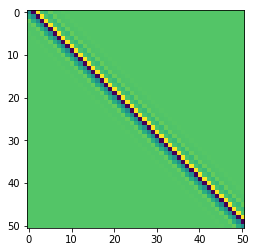

In [377]:
plt.imshow(M.real)

In [378]:
def Covariance_matrix(L,Gamma=Gamma,Lambda=Lambda,beta=0.40824,mu=0,N_size=N_size,Ground=False):
    if Ground:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=True)
    else:
        Fourier_plus,Fourier_minous=Get_Bands_Matrix(Gamma=Gamma,Lambda=Lambda,N_size=N_size,beta=beta,mu=mu,Ground=False)
    return (Toeplitz_matrix(Fourier_plus,L)+Hankel_matrix(Fourier_minous,L))/N_size

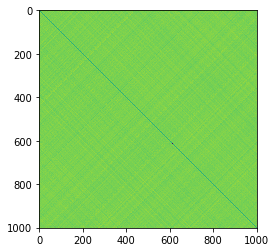

In [379]:
plt.imshow(Covariance_matrix(1001).real)